**Proyek: Analisis Data Penerbangan**

**Tujuan: menerapkan teknik Analisis Data Eksplorasi yang telah dipelajari untuk menganalisis kumpulan data penerbangan dan temukan wawasan yang dapat ditindaklanjuti.**

---

In [209]:
# Load Dataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

flight_df = pd.read_csv('goibibo_flights_data.csv')
flight_df.head()


,flight date,airline,flight_num,class,from,dep_time,to,arr_time,duration,price,stops,Unnamed: 11,Unnamed: 12
0,26-06-2023,SpiceJet,SG-8709,economy,Delhi,18:55,Mumbai,21:05,02h 10m,"6,013",non-stop,NaN,NaN
1,26-06-2023,SpiceJet,SG-8157,economy,Delhi,06:20,Mumbai,08:40,02h 20m,"6,013",non-stop,NaN,NaN
2,26-06-2023,AirAsia,I5-764,economy,Delhi,04:25,Mumbai,06:35,02h 10m,"6,016",non-stop,NaN,NaN
3,26-06-2023,Vistara,UK-995,economy,Delhi,10:20,Mumbai,12:35,02h 15m,"6,015",non-stop,NaN,NaN
4,26-06-2023,Vistara,UK-963,economy,Delhi,08:50,Mumbai,11:10,02h 20m,"6,015",non-stop,NaN,NaN


In [210]:
print(flight_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   flight date  300261 non-null  object 
 1   airline      300261 non-null  object 
 2   flight_num   300261 non-null  object 
 3   class        300261 non-null  object 
 4   from         300261 non-null  object 
 5   dep_time     300261 non-null  object 
 6   to           300261 non-null  object 
 7   arr_time     300261 non-null  object 
 8   duration     300261 non-null  object 
 9   price        300261 non-null  object 
 10  stops        300261 non-null  object 
 11  Unnamed: 11  0 non-null       float64
 12  Unnamed: 12  0 non-null       float64
dtypes: float64(2), object(11)
memory usage: 29.8+ MB
None


**1. Pembersihan dan Pra-pemrosesan Data:**

- Tangani nilai yang hilang.
- Ubah tipe data yang tidak konsisten (misalnya, ubah "Total_Stops" dari objek menjadi integer ).
- Buat fitur baru dari kolom yang ada (misalnya, ekstrak bulan, hari kerja, dan jam dari kolom tanggal/waktu ).


***Tangani nilai yang hilang***

In [211]:
print(flight_df.isna().sum())

flight date         0
airline             0
flight_num          0
class               0
from                0
dep_time            0
to                  0
arr_time            0
duration            0
price               0
stops               0
Unnamed: 11    300261
Unnamed: 12    300261
dtype: int64


In [212]:
#1. handling missing Value
flight_df.dropna(axis=1, how='all', inplace=True)

In [213]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   flight date  300261 non-null  object
 1   airline      300261 non-null  object
 2   flight_num   300261 non-null  object
 3   class        300261 non-null  object
 4   from         300261 non-null  object
 5   dep_time     300261 non-null  object
 6   to           300261 non-null  object
 7   arr_time     300261 non-null  object
 8   duration     300261 non-null  object
 9   price        300261 non-null  object
 10  stops        300261 non-null  object
dtypes: object(11)
memory usage: 25.2+ MB


***ubah datatype yang tidak konsisten***

In [214]:
#001 ubah tipe data stop jadi integer

# Lihat nilai-nilai unik di kolom 'stops' untuk memahami formatnya
# print("Nilai unik di kolom 'stops' sebelum diubah:")
# print(flight_df['stops'].unique())

# Ganti nilai teks 'non-stop' menjadi '0'
flight_df['stops'] = flight_df['stops'].str.replace('non-stop', '0', regex=False)

# Ekstrak hanya angka dari string (misal, '1 stop' akan menjadi '1')
# .str.extract('(\d+)') adalah cara cepat untuk mengambil digit pertama dari teks
flight_df['stops'] = flight_df['stops'].str.extract(r'(\d+)').astype(int)

# #  Cek kembali tipe data untuk memastikan sudah berubah
# print("\nTipe data kolom 'stops' setelah diubah:")
# print(flight_df[['stops']].info())


In [215]:
## ## 1. Membersihkan Kolom price (Harga)

# Hapus karakter koma dari kolom 'price'
flight_df['price'] = flight_df['price'].str.replace(',', '')

# Ubah tipe data 'price' menjadi angka (integer)
# Kita gunakan errors='coerce' untuk mengubah nilai yang tidak bisa diubah menjadi NaN (kosong)
flight_df['price'] = pd.to_numeric(flight_df['price'], errors='coerce')

# Hapus baris yang harganya menjadi NaN setelah konversi (jika ada)
flight_df.dropna(subset=['price'], inplace=True)

# Ubah menjadi integer jika tidak ada desimal
flight_df['price'] = flight_df['price'].astype(int)

In [216]:
## 2. Mengonversi Kolom flight_date (Tanggal Penerbangan)

# Ubah 'flight_date' menjadi format datetime
flight_df['flight date'] = pd.to_datetime(flight_df['flight date'], format='%d-%m-%Y')

In [217]:
## 3. Mengurai Kolom duration (Durasi)

# -- ini bagian yang paling rumit. Durasi dalam format "2h 30m" tidak bisa langsung dianalisis.
#  Kita perlu mengubahnya menjadi satu unit, misalnya total menit. Kita akan membuat fungsi khusus untuk ini.

def ubah_durasi_ke_menit(durasi):
    try:
        # Pisahkan jam (h) dan menit (m)
        jam = 0
        menit = 0
        parts = durasi.split(' ')
        for part in parts:
            if 'h' in part:
                jam = int(part.replace('h', ''))
            elif 'm' in part:
                menit = int(part.replace('m', ''))
        return (jam * 60) + menit
    except:
        return None # Kembalikan None jika formatnya aneh

# Terapkan fungsi tersebut ke kolom 'duration' untuk membuat kolom baru
flight_df['duration_in_minutes'] = flight_df['duration'].apply(ubah_durasi_ke_menit)

# Hapus kolom 'duration' yang lama karena sudah tidak terpakai
flight_df.drop('duration', axis=1, inplace=True)

In [218]:
# 4. Mengekstrak Jam dari dep_time dan arr_time

# Untuk waktu keberangkatan dan kedatangan, seringkali yang paling berguna untuk analisis adalah jam-nya. 
# Kita bisa mengekstrak jam dari teks seperti "14:30".

# Ekstrak jam keberangkatan dan ubah menjadi angka
flight_df['dep_hour'] = flight_df['dep_time'].str.split(':').str[0].astype(int)

# Ekstrak jam kedatangan dan ubah menjadi angka
flight_df['arr_hour'] = flight_df['arr_time'].str.split(':').str[0].astype(int)

# Hapus kolom waktu yang lama
flight_df.drop(['dep_time', 'arr_time'], axis=1, inplace=True)

In [219]:
# 5. Ubah beberapa kolom ke kategori
for col in ["airline", "class", "from", "to"]:
    flight_df[col] = flight_df[col].astype("category")

In [220]:
print("\n--- TIPE DATA SETELAH DIBERSIHKAN ---")
print(flight_df.info())


--- TIPE DATA SETELAH DIBERSIHKAN ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   flight date          300261 non-null  datetime64[ns]
 1   airline              300261 non-null  category      
 2   flight_num           300261 non-null  object        
 3   class                300261 non-null  category      
 4   from                 300261 non-null  category      
 5   to                   300261 non-null  category      
 6   price                300261 non-null  int32         
 7   stops                300261 non-null  int32         
 8   duration_in_minutes  300257 non-null  float64       
 9   dep_hour             300261 non-null  int32         
 10  arr_hour             300261 non-null  int32         
dtypes: category(4), datetime64[ns](1), float64(1), int32(4), object(1)
memory usage: 12.6+ MB
N

In [221]:
#drop dlu nangguung nilai yang berhubungan dengan baris missing value

# Cek jumlah baris sebelum dihapus
print(f"Jumlah baris sebelum drop: {len(flight_df)}")

# Drop baris dimana kolom 'duration_in_minutes' nilainya kosong
flight_df.dropna(subset=['duration_in_minutes'], inplace=True)

# Cek jumlah baris setelah dihapus untuk konfirmasi
print(f"Jumlah baris setelah drop: {len(flight_df)}")

# Cek kembali info untuk memastikan tidak ada lagi missing value
flight_df.info()

Jumlah baris sebelum drop: 300261
Jumlah baris setelah drop: 300257
<class 'pandas.core.frame.DataFrame'>
Index: 300257 entries, 0 to 300260
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   flight date          300257 non-null  datetime64[ns]
 1   airline              300257 non-null  category      
 2   flight_num           300257 non-null  object        
 3   class                300257 non-null  category      
 4   from                 300257 non-null  category      
 5   to                   300257 non-null  category      
 6   price                300257 non-null  int32         
 7   stops                300257 non-null  int32         
 8   duration_in_minutes  300257 non-null  float64       
 9   dep_hour             300257 non-null  int32         
 10  arr_hour             300257 non-null  int32         
dtypes: category(4), datetime64[ns](1), float64(1), int32(4), object(1)


In [222]:
print(flight_df)


       flight date   airline flight_num     class     from         to  price  \
0       2023-06-26  SpiceJet    SG-8709   economy    Delhi     Mumbai   6013   
1       2023-06-26  SpiceJet    SG-8157   economy    Delhi     Mumbai   6013   
2       2023-06-26   AirAsia     I5-764   economy    Delhi     Mumbai   6016   
3       2023-06-26   Vistara     UK-995   economy    Delhi     Mumbai   6015   
4       2023-06-26   Vistara     UK-963   economy    Delhi     Mumbai   6015   
...            ...       ...        ...       ...      ...        ...    ...   
300256  2023-08-13   Vistara     UK-822  business  Chennai  Hyderabad  70304   
300257  2023-08-13   Vistara     UK-826  business  Chennai  Hyderabad  78262   
300258  2023-08-13   Vistara     UK-832  business  Chennai  Hyderabad  80285   
300259  2023-08-13   Vistara     UK-828  business  Chennai  Hyderabad  82809   
300260  2023-08-13   Vistara     UK-822  business  Chennai  Hyderabad  82809   

        stops  duration_in_minutes  dep

---

**2. Analisis Data Eksplorasi:**
- Analisis distribusi harga tiket pesawat.
- Jelajahi hubungan atau perbadingan antara harga tiket dan variabel lain seperti maskapai, durasi penerbangan, dan jumlah perhentian.
- Gunakan tabulasi silang untuk menganalisis hubungan antara variabel kategorikal (misalnya, sumber dan tujuan ).
- Buat kategori harga baru (misalnya, Ekonomi, Ekonomi Premium, Kelas Bisnis, Kelas Utama) menggunakan pd.cut().
- Visualisasikan temuan Anda menggunakan scatterplot, barplot, heatmap, dan countplot.



***distribusi tiket harga pesawat***

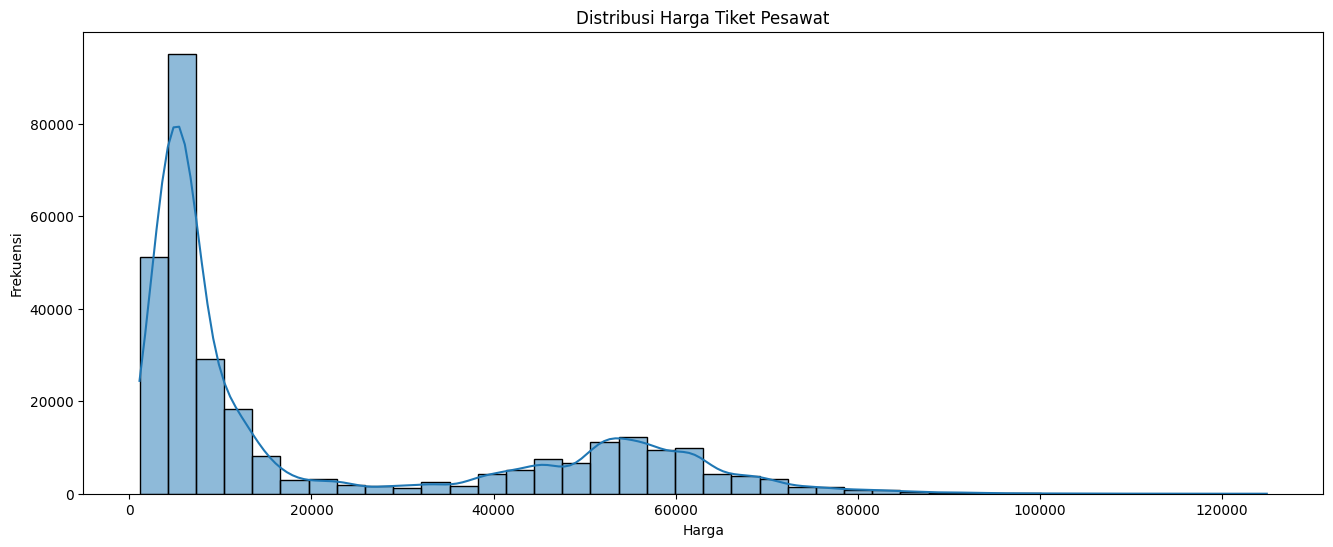

In [223]:
# --- Distribusi harga tiket --
plt.figure(figsize=(16, 6))
sns.histplot(flight_df['price'], bins=40, kde=True)
plt.title('Distribusi Harga Tiket Pesawat')
plt.xlabel('Harga')
plt.ylabel('Frekuensi')
plt.show()

***perbandingan harga tiket per maskapai***

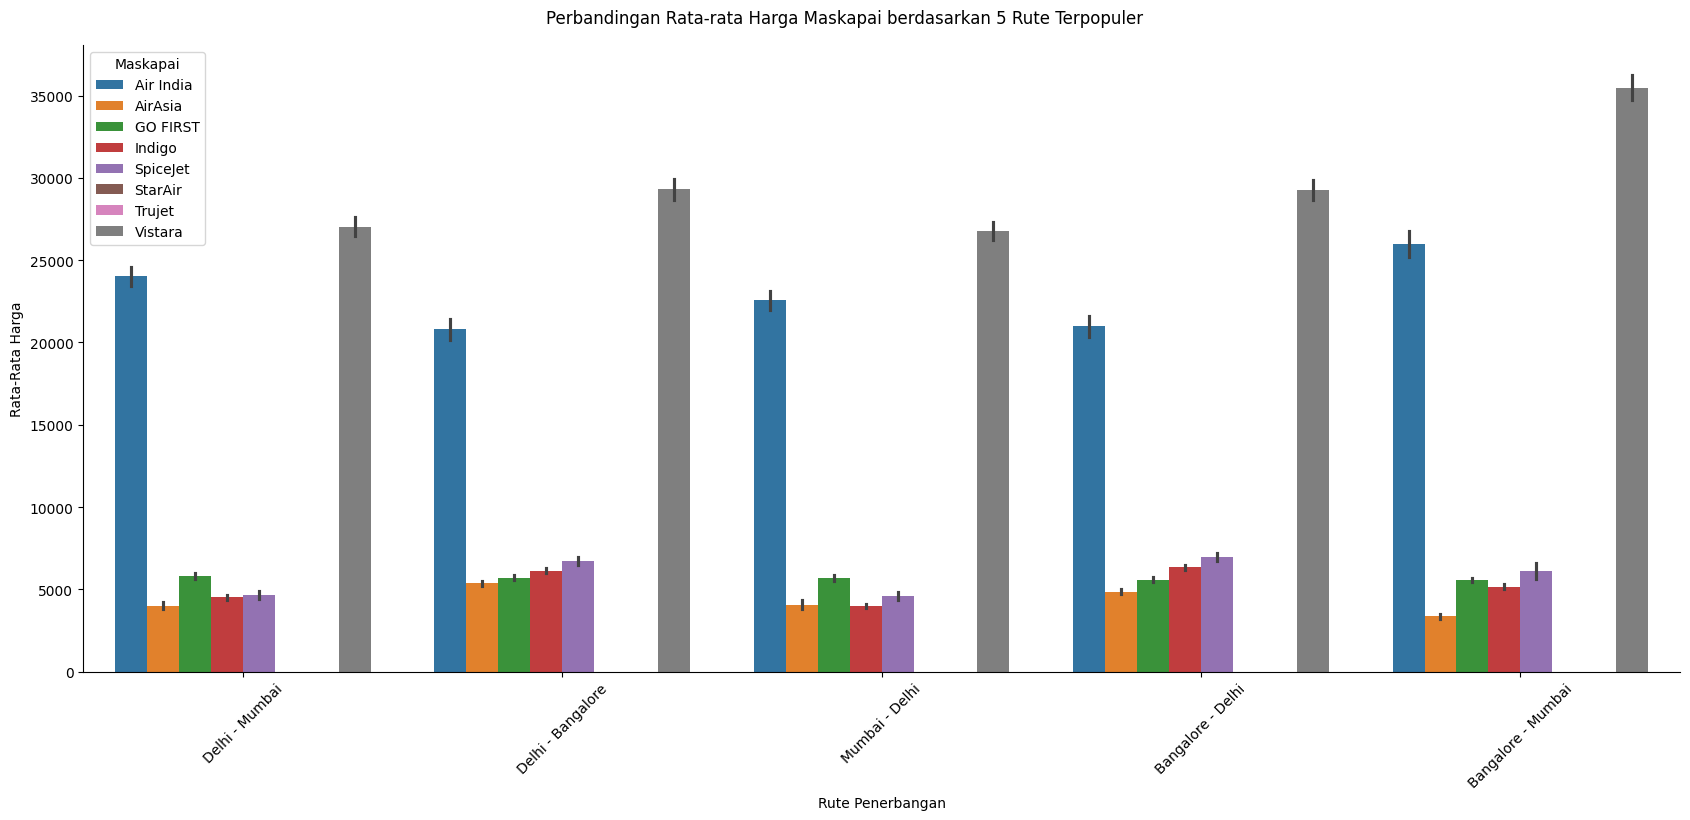

In [224]:
# Membuat kolom 'route' dengan format "Asal - Tujuan"
flight_df['route'] = flight_df['from'].astype(str) + ' - ' + flight_df['to'].astype(str)

# print("Contoh isi kolom 'route' yang baru dibuat:")
# print(flight_df['route'].head())

# Hitung frekuensi setiap rute
top_routes = flight_df['route'].value_counts().nlargest(5).index

# print("\n6 Rute Paling Populer:")
# print(top_routes)

# Filter DataFrame agar hanya berisi data dari rute-rute populer ini
df_top_routes = flight_df[flight_df['route'].isin(top_routes)]


# Buat barplot untuk membandingkan harga maskapai di setiap rute populer
g = sns.catplot(data=df_top_routes,
                x='route',
                y='price',
                hue='airline', # Bedakan warna berdasarkan maskapai
                kind='bar',
                height=7,
                aspect=17/7,
                legend_out=False)

# Atur judul dan label
g.fig.suptitle('Perbandingan Rata-rata Harga Maskapai berdasarkan 5 Rute Terpopuler', y=1.03)
g.set_xticklabels(rotation=45)
g.set_axis_labels("Rute Penerbangan", "Rata-Rata Harga")

# Pindahkan legend (keterangan warna) ke lokasi yang lebih baik
g.add_legend(title='Maskapai')

plt.show()

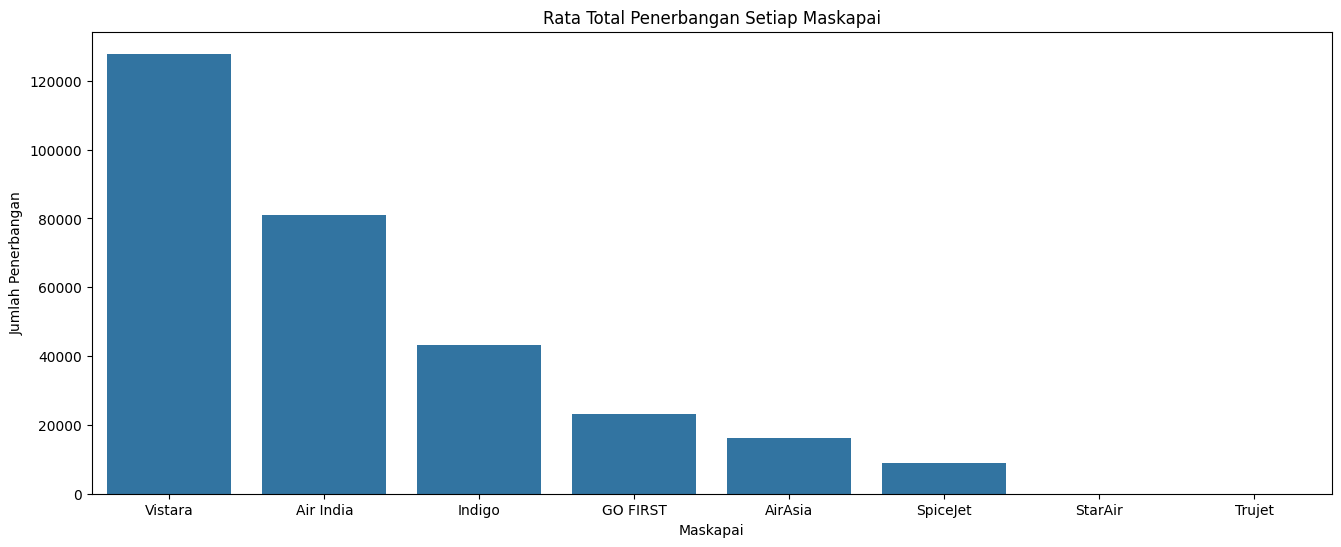

In [225]:
#hitung rata-rata frekuensi penerbangan dari setiap maskapai
avg_airline = flight_df['airline'].sort_values(ascending=False).reset_index()
plt.figure(figsize=(16,6))
sns.countplot(data=flight_df,
              x='airline',
              order=flight_df['airline'].value_counts().index)
plt.title("Rata Total Penerbangan Setiap Maskapai")
plt.xlabel("Maskapai")
plt.ylabel("Jumlah Penerbangan")
plt.show()


***Hubungan Durasi penerbangan dan harga tiket***

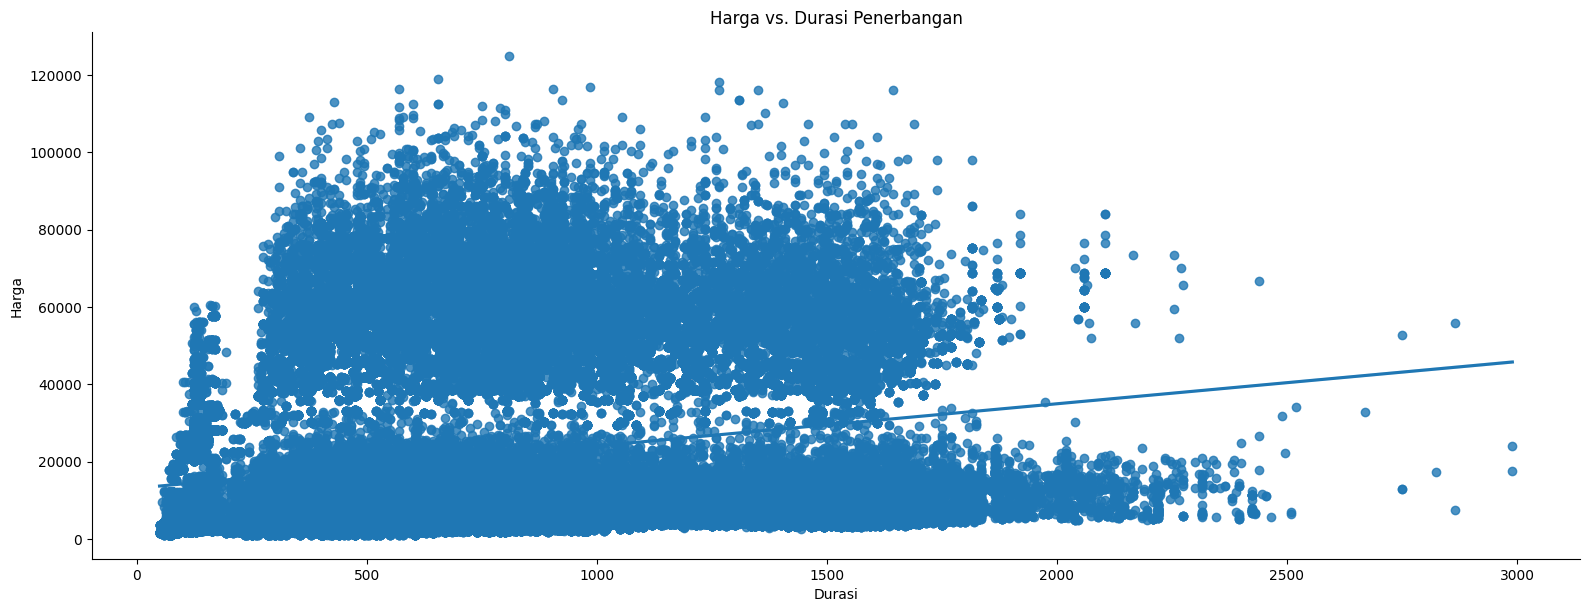

In [226]:
# --- Hubungan antara Harga dan Durasi Penerbangan ---
# 
sns.lmplot(x='duration_in_minutes', 
           y='price', 
           data=flight_df,
           aspect=16/6,
           height=6)
plt.title('Harga vs. Durasi Penerbangan')
plt.xlabel('Durasi')
plt.ylabel('Harga')
plt.show()

In [227]:
flight_df['duration_in_minutes'].corr(flight_df['price']).round(5)

0.20428

***Perbandingan harga tiket dan jumlah pemberhentian***

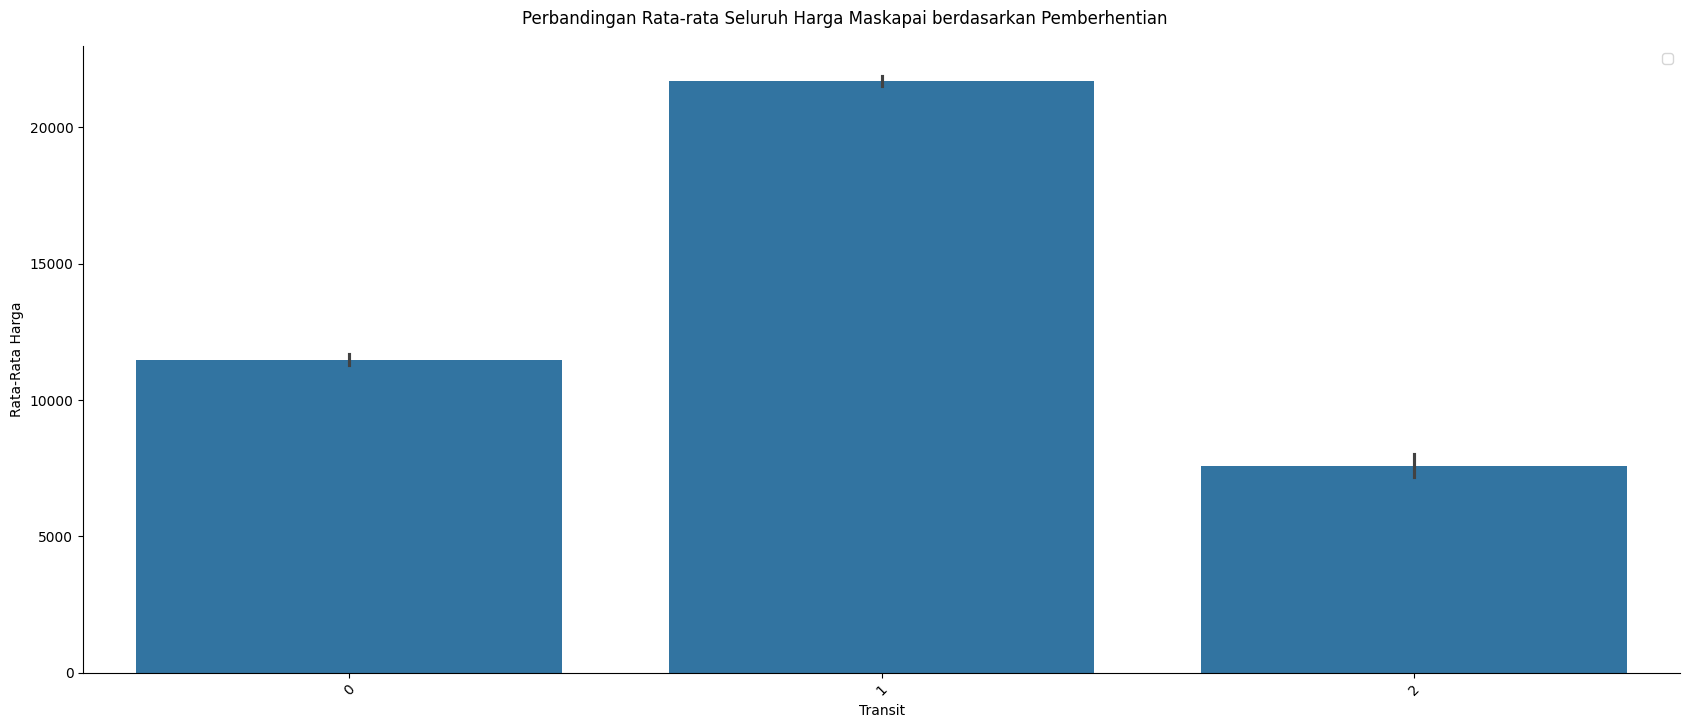

In [228]:
g2 = sns.catplot(data=df_top_routes,
                x='stops',
                y='price',
                # hue='airline', # Bedakan warna berdasarkan maskapai
                kind='bar',
                height=7,
                aspect=17/7,
                legend_out=False)

# Atur judul dan label
g2.fig.suptitle('Perbandingan Rata-rata Seluruh Harga Maskapai berdasarkan Pemberhentian', y=1.03)
g2.set_xticklabels(rotation=45)
g2.set_axis_labels("Transit", "Rata-Rata Harga")
# g2.add_legend(title='Maskapai')

**harga tiket x jam keberangkatan**

In [229]:
# 1. Hitung Frekuensi Penerbangan per Jam
hourly_frequency = flight_df['dep_hour'].value_counts()

# 2. Hitung Rata-Rata Harga per Jam
hourly_avg_price = flight_df.groupby('dep_hour')['price'].mean()

# 3. Gabungkan kedua data tersebut menjadi satu DataFrame baru
# Pandas akan secara otomatis menyelaraskannya berdasarkan jam (indeks)
freq_price_df = pd.DataFrame({
    'frequency': hourly_frequency,
    'average_price': hourly_avg_price
})

print("Data Gabungan Frekuensi dan Rata-Rata Harga per Jam:")
print(freq_price_df.head())



Data Gabungan Frekuensi dan Rata-Rata Harga per Jam:
          frequency  average_price
dep_hour                          
0               303    3955.917492
1                98    4901.836735
2               619   14951.327948
3               170    4182.447059
4              2420    7253.380579


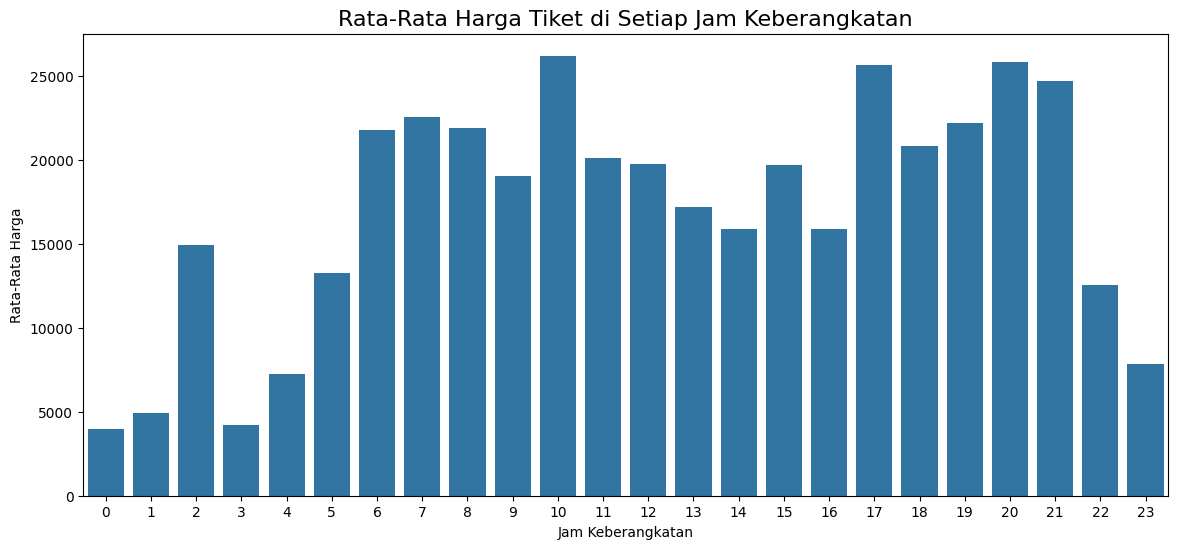

In [230]:
plt.figure(figsize=(14, 6))
sns.barplot(x=hourly_avg_price.index, y=hourly_avg_price.values)
plt.title('Rata-Rata Harga Tiket di Setiap Jam Keberangkatan', fontsize=16)
plt.xlabel('Jam Keberangkatan')
plt.ylabel('Rata-Rata Harga')
plt.show()

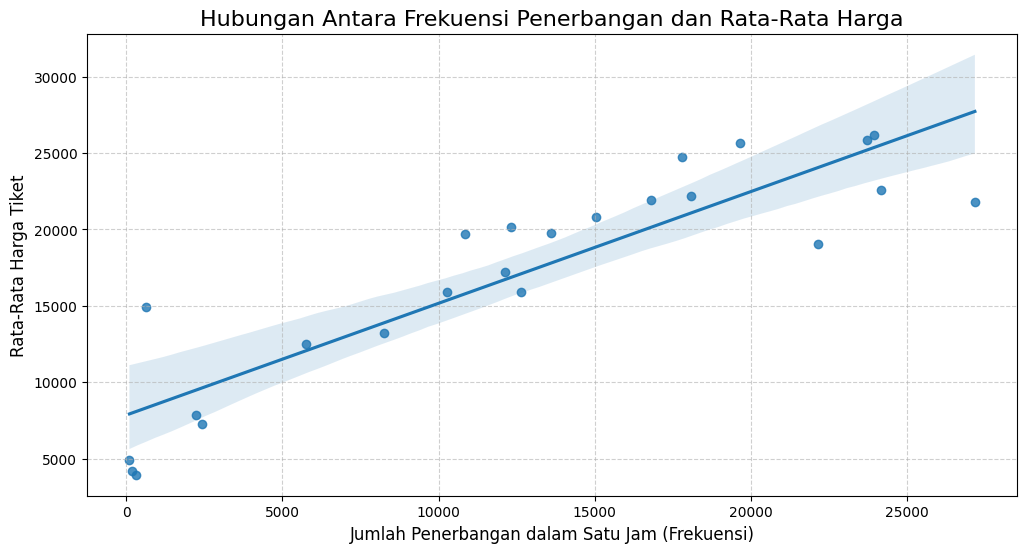

In [231]:
# Kita gunakan regplot untuk melihat scatter plot beserta garis tren (regresi)
plt.figure(figsize=(12, 6))
sns.regplot(data=freq_price_df, x='frequency', y='average_price')

plt.title('Hubungan Antara Frekuensi Penerbangan dan Rata-Rata Harga', fontsize=16)
plt.xlabel('Jumlah Penerbangan dalam Satu Jam (Frekuensi)', fontsize=12)
plt.ylabel('Rata-Rata Harga Tiket', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

***hubungan asal dan tujuan dengan crosstab***

Cross tab Frekuensi Rute (dari 'from' ke 'to'= total penerbangan):


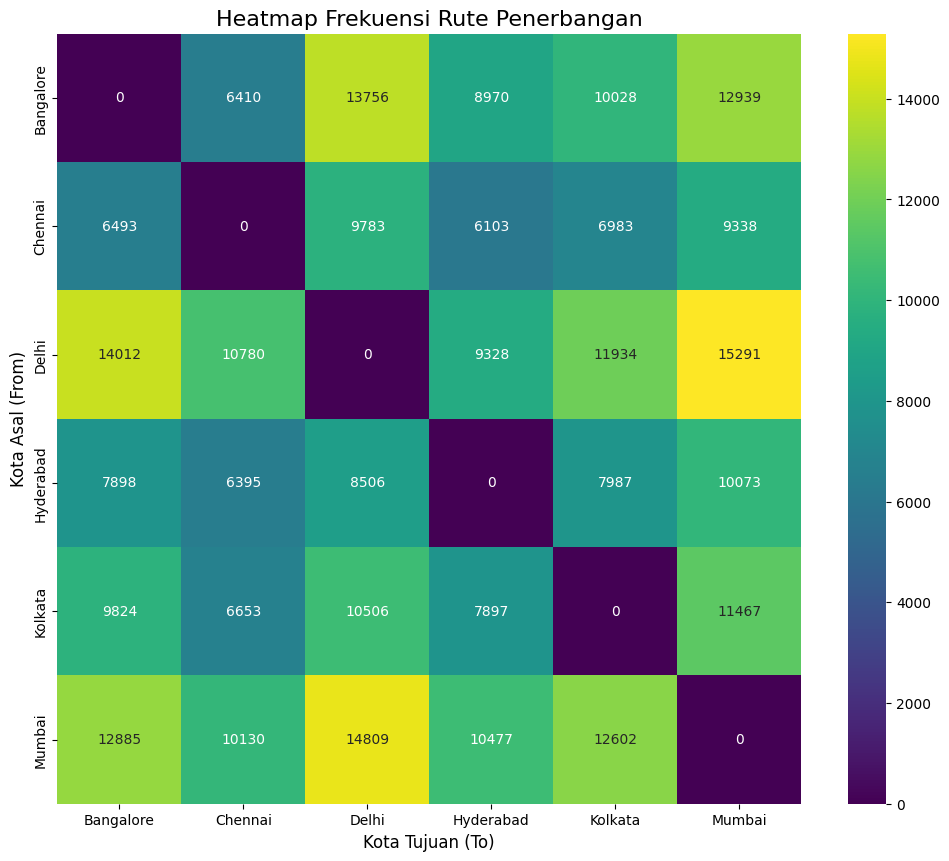

In [232]:
route_crosstab = pd.crosstab(flight_df['from'], flight_df['to'])

print("Cross tab Frekuensi Rute (dari 'from' ke 'to'= total penerbangan):")
# print(route_crosstab)


plt.figure(figsize=(12, 10))

# Membuat heatmap dari hasil tabulasi silang
sns.heatmap(route_crosstab, cmap='viridis', annot=True, fmt='d')
# cmap='viridis' -> skema warna
# annot=True -> tampilkan angka di setiap sel
# fmt='d' -> format angka sebagai integer

plt.title('Heatmap Frekuensi Rute Penerbangan', fontsize=16)
plt.xlabel('Kota Tujuan (To)', fontsize=12)
plt.ylabel('Kota Asal (From)', fontsize=12)
plt.show()

---

**Pembuatan Hipotesis:**

**tiga hipotesis tentang faktor-faktor yang memengaruhi harga tiket pesawat.**

- Penerbangan dengan lebih banyak perhentian memiliki rata-rata harga tiket yang lebih rendah.
- hubungan durasi penerbangan dan hargai tidak berada pada 0.204 meskipun ada tetapi sangat lemah kemungkinan tidak signifikan dalam mempengaruhi harga tiket
- semakin premium maskapai semakin mahal juga harga tiket pesawat


**4. Presentasi:**
 - Pendorong Utama Harga: Analisis menunjukkan bahwa harga tiket sangat dipengaruhi oleh tiga faktor utama: maskapai penerbangan, jumlah perhentian (stops), dan durasi penerbangan. Maskapai full-service secara konsisten memiliki harga rata-rata yang jauh lebih tinggi, dan penambahan jumlah perhentian secara signifikan menaikkan harga tiket.

 - Dinamika Rute Populer: Rute penerbangan memiliki pengaruh kuat terhadap struktur harga. Analisis mengidentifikasi enam rute terpopuler dengan tingkat permintaan tertinggi. Di rute-rute ini, persaingan harga antar maskapai menjadi sangat jelas terlihat, di mana beberapa maskapai secara konsisten menjadi pilihan premium dan yang lainnya menjadi pilihan ekonomis.

 - Pola Harga Berdasarkan Waktu: Terdapat pola yang menunjukkan bahwa jam keberangkatan mempengaruhi harga. Harga tiket cenderung lebih tinggi pada jam-jam sibuk (pagi dan sore hari), yang mengindikasikan adanya strategi penetapan harga berdasarkan permintaan puncak (peak hour demand).

 - Konektivitas Jaringan: Visualisasi tabulasi silang (heatmap) menunjukkan jaringan penerbangan yang terpusat di beberapa kota besar yang berfungsi sebagai hub, dengan frekuensi penerbangan yang sangat tinggi di antara mereka, sementara konektivitas ke kota-kota lain lebih jarang.



**Wawasan**
1. Harga sangat bervariasi berdasarkan maskapai dan rute.
- Aksi untuk Maskapai (Strategi Harga): Temuan ini bisa menjadi dasar untuk strategi harga yang dinamis dan kompetitif.
    - Untuk Rute Unggulan: Pada rute di mana maskapai Anda adalah pemimpin pasar dengan harga premium (contoh: Vistara di beberapa rute), maskapai bisa fokus menawarkan paket bundling (misal: dengan bagasi ekstra, pilihan kursi) untuk memaksimalkan pendapatan.
    - Untuk Rute Kompetitif: Pada rute di mana harga maskapai Anda lebih rendah (contoh: SpiceJet atau IndiGo), temuan ini bisa digunakan untuk kampanye pemasaran yang menonjolkan "Best Value" atau "Harga Paling Terjangkau di Rute X".


2. Ada beberapa rute yang sangat populer dan sibuk.
- Aksi untuk Maskapai (Manajemen Rute & Armada):
    - Optimalisasi Frekuensi: Maskapai dapat menambah frekuensi penerbangan pada 6 rute terpopuler yang sudah diidentifikasi untuk   menangkap lebih banyak permintaan.
    - Penyesuaian Armada: Jika sebuah rute populer memiliki persaingan harga yang ketat, maskapai bisa mempertimbangkan untuk menggunakan pesawat berbadan lebih besar di rute tersebut untuk menekan biaya per kursi dan meningkatkan margin keuntungan.

3. Wawasan: Harga lebih mahal pada jam-jam sibuk.
- Aksi untuk Maskapai (Pemasaran & Manajemen Pendapatan):
    - Promosi Off-Peak: Untuk meningkatkan tingkat keterisian pesawat (load factor), tim pemasaran bisa meluncurkan promo diskon khusus untuk jam-jam sepi (misalnya, penerbangan antara jam 11 pagi - 3 sore).

    - Harga Fleksibel: Menawarkan tingkatan harga yang berbeda untuk tiket yang dibeli jauh-jauh hari versus mendekati jam puncak untuk memaksimalkan pendapatan.


**Kesimpulannya adalah bahwa harga tiket pesawat bukanlah angka tunggal yang acak, melainkan hasil dari interaksi kompleks antara beberapa faktor kunci yang dapat diidentifikasi dan dikelola secara strategis.**


---